<a href="https://colab.research.google.com/github/TigranYeghiazaryan/Asthma/blob/main/asthma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'copd-asthma-patient-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4425232%2F7601541%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T184849Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D635bf685f972f8e35475b23a4c85add94525cba4c137fa551e93370efd740d55daadb262b9d5a531621eb48635c553d9e3d054aee4411528a41732c9b85fa3b233cf6ea5bc9d6ae9bc4c6b1573487e24bfb07857e4f8924e4faf86bd7f4ed0a3e388baa6e2448585ce12716d230db80b5e2b8c9cca11edc6726c1449d056020cfc16038cfd43135b188fe7fc99e2e81469611f486f3abaa2c2192145dcbc0c2f80010dd2d33d727df9fc39349a04816867d5f891449f6fd7d113af0584eca253683b90fd02eac99dced8651e9ed6d6b06ad7f25b92cfc2ae5ba66ebc8c9f2bf1273b7414eaa085b43ec0304e4ecdff3c76d33141349f373ec3c01a9b352db752'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2651 bytes downloaded
Downloaded and uncompressed: copd-asthma-patient-dataset
Data source import complete.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/copd-asthma-patient-dataset/asthma_dataset.csv


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/copd-asthma-patient-dataset/asthma_dataset.csv


In [4]:
df = pd.read_csv("/kaggle/input/copd-asthma-patient-dataset/asthma_dataset.csv")


In [5]:
df.head()

,Patient_ID,Age,Gender,Smoking_Status,Asthma_Diagnosis,Medication,Peak_Flow
0,1,26,Female,Non-Smoker,Yes,Inhaler,175
1,2,52,Female,Ex-Smoker,No,None,156
2,3,56,Female,Ex-Smoker,Yes,Inhaler,236
3,4,55,Male,Current Smoker,Yes,Controller Medication,378
4,5,43,Female,Current Smoker,No,None,159


In [6]:
df.columns

Index(['Patient_ID', 'Age', 'Gender', 'Smoking_Status', 'Asthma_Diagnosis',
       'Medication', 'Peak_Flow'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Patient_ID        300 non-null    int64 
 1   Age               300 non-null    int64 
 2   Gender            300 non-null    object
 3   Smoking_Status    300 non-null    object
 4   Asthma_Diagnosis  300 non-null    object
 5   Medication        300 non-null    object
 6   Peak_Flow         300 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 16.5+ KB


In [8]:
df['Medication'] = df['Medication'].fillna('No Medication')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Patient_ID        300 non-null    int64 
 1   Age               300 non-null    int64 
 2   Gender            300 non-null    object
 3   Smoking_Status    300 non-null    object
 4   Asthma_Diagnosis  300 non-null    object
 5   Medication        300 non-null    object
 6   Peak_Flow         300 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 16.5+ KB


In [10]:
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    unique_values = df[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in Gender: ['Female' 'Male']
Unique values in Smoking_Status: ['Non-Smoker' 'Ex-Smoker' 'Current Smoker']
Unique values in Asthma_Diagnosis: ['Yes' 'No']
Unique values in Medication: ['Inhaler' 'None' 'Controller Medication']


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Patient_ID        300 non-null    int64 
 1   Age               300 non-null    int64 
 2   Gender            300 non-null    object
 3   Smoking_Status    300 non-null    object
 4   Asthma_Diagnosis  300 non-null    object
 5   Medication        300 non-null    object
 6   Peak_Flow         300 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 16.5+ KB


In [12]:
summary_stats = df.describe()
print(summary_stats)

       Patient_ID         Age   Peak_Flow
count  300.000000  300.000000  300.000000
mean   150.500000   39.666667  278.943333
std     86.746758   14.059675   72.861027
min      1.000000   18.000000  150.000000
25%     75.750000   27.000000  216.500000
50%    150.500000   39.000000  279.000000
75%    225.250000   51.000000  340.250000
max    300.000000   65.000000  400.000000


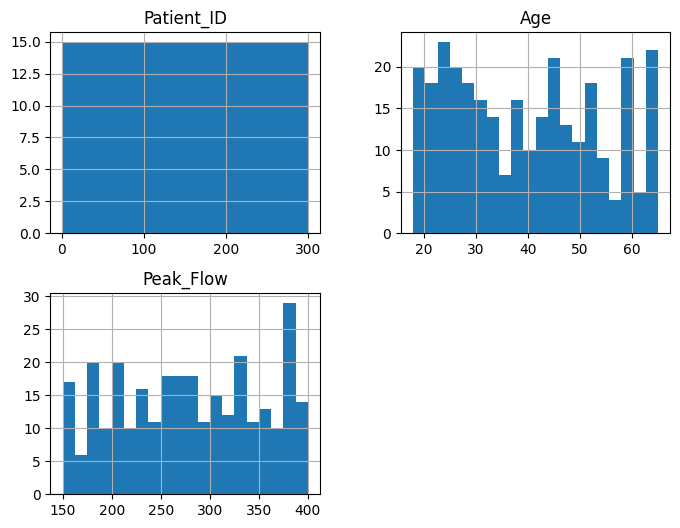

In [13]:
numerical_columns = df.select_dtypes(include=['int64']).columns
df[numerical_columns].hist(bins=20, figsize=(8, 6))
plt.show()

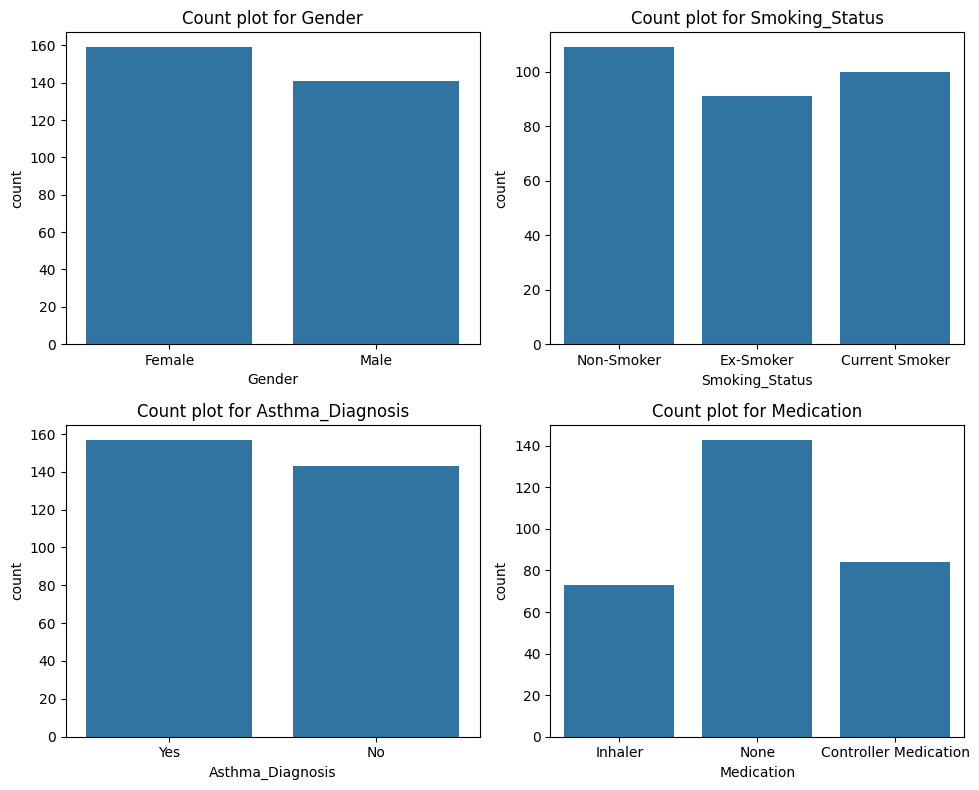

In [14]:
categorical_columns = df.select_dtypes(include=['object']).columns

# Set up subplots with two columns and two rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot count plots for the first two categorical columns in the first row
for i, column in enumerate(categorical_columns[:2]):
    sns.countplot(x=column, data=df, ax=axes[0, i])
    axes[0, i].set_title(f'Count plot for {column}')

# Plot count plots for the next two categorical columns in the second row
for i, column in enumerate(categorical_columns[2:]):
    sns.countplot(x=column, data=df, ax=axes[1, i])
    axes[1, i].set_title(f'Count plot for {column}')

plt.tight_layout()
plt.show()

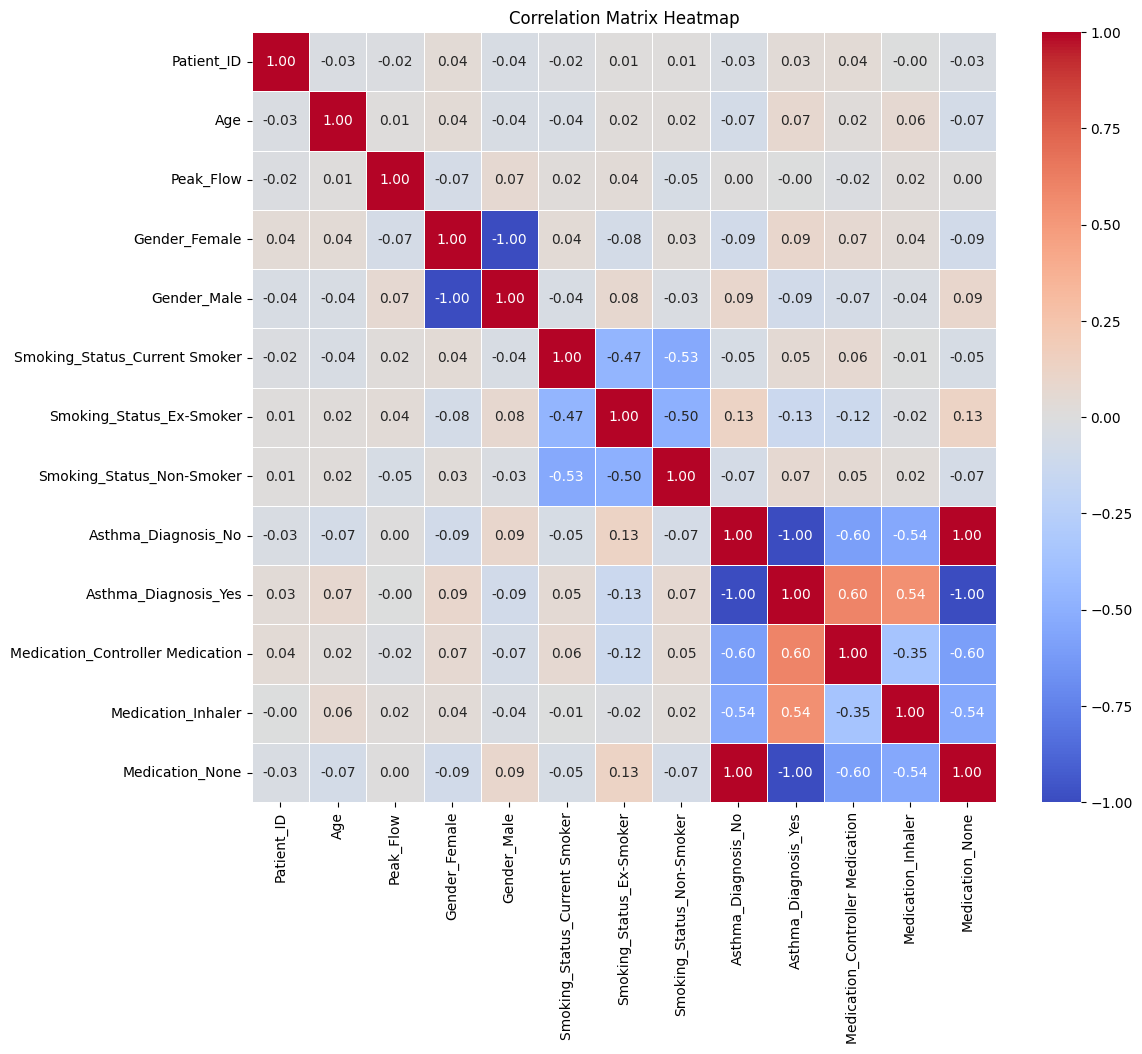

In [15]:
# Convert categorical columns to one-hot encoding
df_encoded = pd.get_dummies(df, columns=['Gender', 'Smoking_Status', 'Asthma_Diagnosis', 'Medication'])

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

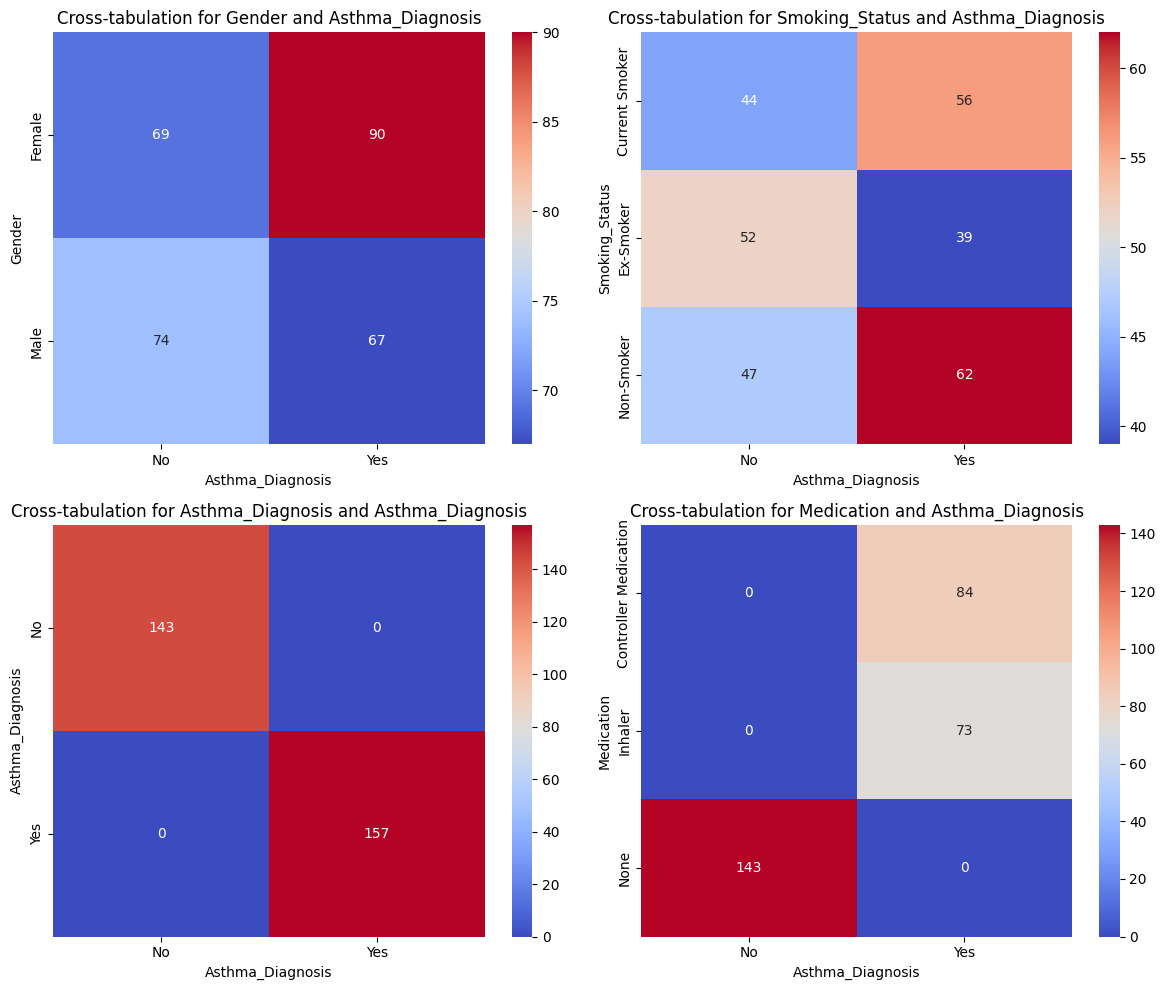

In [16]:
categorical_columns = ['Gender', 'Smoking_Status', 'Asthma_Diagnosis', 'Medication']

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Iterate through categorical columns and plot heatmaps
for i, column in enumerate(categorical_columns):
    row, col = divmod(i, 2)
    cross_tab = pd.crosstab(df[column], df['Asthma_Diagnosis'])
    sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d', ax=axes[row, col])
    axes[row, col].set_title(f'Cross-tabulation for {column} and Asthma_Diagnosis')

# Adjust layout
plt.tight_layout()
plt.show()